In [1]:
import pyspark
from pyspark.mllib.stat import Statistics
from csv import reader
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
sns.set_style('white')

In [12]:
# for displaying data
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 100)

In [2]:
# read data into RDD
data = sc.textFile('./NYPD_Complaint_Data_Historic.csv', 1) \
          .mapPartitions(lambda x: reader(x))

In [3]:
# get column names
header = data.first()

In [4]:
CMPLNT_NUM=0
CMPLNT_FR_DT=1
CMPLNT_FR_TM=2
CMPLNT_TO_DT=3
CMPLNT_TO_TM=4
RPT_DT=5
KY_CD=6
OFNS_DESC=7
PD_CD=8
PD_DESC=9
CRM_ATPT_CPTD_CD=10
LAW_CAT_CD=11
JURIS_DESC=12
BORO_NM=13
ADDR_PCT_CD=14
LOC_OF_OCCUR_DESC=15
PREM_TYP_DESC=16
PARKS_NM=17
HADEVELOPT=18
X_COORD_CD=19
Y_COORD_CD=20
LATITUDE=21
LONGTITUDE=22

In [5]:
# remove first line
data = data.filter(lambda x: x != header)
pd.DataFrame(data.take(10), columns=header)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,,,12/31/2015,113,FORGERY,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44,INSIDE,BAR/NIGHT CLUB,,,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,,,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,,,...,103,OUTSIDE,,,,1043991,193406,40.697338138,-73.784556739,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,,,12/31/2015,117,DANGEROUS DRUGS,503,"CONTROLLED SUBSTANCE,INTENT TO",...,28,,OTHER,,,999463,231690,40.802606608,-73.945051911,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,,,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,105,INSIDE,RESIDENCE-HOUSE,,,1060183,177862,40.654549444,-73.726338791,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,13,FRONT OF,OTHER,,,987606,208148,40.7380024,-73.98789129,"(40.7380024, -73.98789129)"
5,365661343,12/31/2015,23:18:00,12/31/2015,23:25:00,12/31/2015,106,FELONY ASSAULT,109,"ASSAULT 2,1,UNCLASSIFIED",...,71,FRONT OF,DRUG STORE,,,996149,181562,40.665022689,-73.957110763,"(40.665022689, -73.957110763)"
6,608231454,12/31/2015,23:15:00,,,12/31/2015,235,DANGEROUS DRUGS,511,"CONTROLLED SUBSTANCE, POSSESSI",...,7,OPPOSITE OF,STREET,,,987373,201662,40.720199996,-73.988735082,"(40.720199996, -73.988735082)"
7,265023856,12/31/2015,23:15:00,12/31/2015,23:15:00,12/31/2015,118,DANGEROUS WEAPONS,792,WEAPONS POSSESSION 1 & 2,...,46,FRONT OF,STREET,,,1009041,247401,40.845707148,-73.910398033,"(40.845707148, -73.910398033)"
8,989238731,12/31/2015,23:15:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,48,INSIDE,RESIDENCE - APT. HOUSE,,,1014154,251416,40.856711291,-73.891899956,"(40.856711291, -73.891899956)"
9,415095955,12/31/2015,23:10:00,12/31/2015,23:10:00,12/31/2015,341,PETIT LARCENY,338,"LARCENY,PETIT FROM BUILDING,UN",...,19,INSIDE,DRUG STORE,,,994327,218211,40.765617688,-73.96362342,"(40.765617688, -73.96362342)"


In [8]:
# number of rows
data.count()

5101231

In [9]:
# find number of missing values
missing_count = []
for i in range(24):
    missing_count.append(data.filter(lambda x: len(x[i])==0).count())
missing_count

[0,
 655,
 48,
 1391478,
 1387785,
 0,
 0,
 18840,
 4574,
 4574,
 7,
 0,
 0,
 463,
 390,
 1127128,
 33279,
 5093632,
 4848026,
 188146,
 188146,
 188146,
 188146,
 188146]

## Missing Values

In [10]:
missing = pd.DataFrame(missing_count, columns=['missing'], index=header)
missing

,missing
CMPLNT_NUM,0
CMPLNT_FR_DT,655
CMPLNT_FR_TM,48
CMPLNT_TO_DT,1391478
CMPLNT_TO_TM,1387785
RPT_DT,0
KY_CD,0
OFNS_DESC,18840
PD_CD,4574
PD_DESC,4574


## Aggregate by times and periods

In [17]:
rpt_by_year = data.filter(lambda x: len(x[RPT_DT])>0) \
              .map(lambda x: x[RPT_DT].split('/')[2]) \
              .countByValue()

In [25]:
rpt_by_year_df = pd.DataFrame(list(rpt_by_year.items()), columns=['year','count']).sort_values(by='count', ascending=False).sort_values(by='year')

In [26]:
rpt_by_year_df

,year,count
2,2006,539977
6,2007,538380
5,2008,530034
7,2009,513056
8,2010,509728
3,2011,498576
9,2012,504341
1,2013,497242
0,2014,491319
4,2015,478578


In [20]:
rpt_by_year_dfs = [None]*3
law_cats = ['FELONY', 'MISDEMEANOR', 'VIOLATION']
for i,law_cat in enumerate(law_cats):
    agg = data.filter(lambda x: len(x[RPT_DT])>0 and x[LAW_CAT_CD]==law_cat) \
              .map(lambda x: x[RPT_DT].split('/')[2]) \
              .countByValue()
    rpt_by_year_dfs[i] = pd.DataFrame(list(agg.items()), columns=['year','count']).sort_values(by='count', ascending=False).sort_values(by='year')
    

In [21]:
# only look at years from 2006
cmplnt_fr_dt_by_year = data.filter(lambda x: len(x[CMPLNT_FR_DT])>0) \
              .map(lambda x: x[CMPLNT_FR_DT].split('/')[2]) \
              .filter(lambda x: int(x)>=2006) \
              .countByValue()

In [28]:
cmplnt_fr_dt_by_year_df = pd.DataFrame(list(cmplnt_fr_dt_by_year.items()), columns=['year','count']).sort_values(by='count', ascending=False) \
                          .sort_values(by='year')

In [23]:
rpt_by_year_dfs[2].dtypes

year     object
count     int64
dtype: object

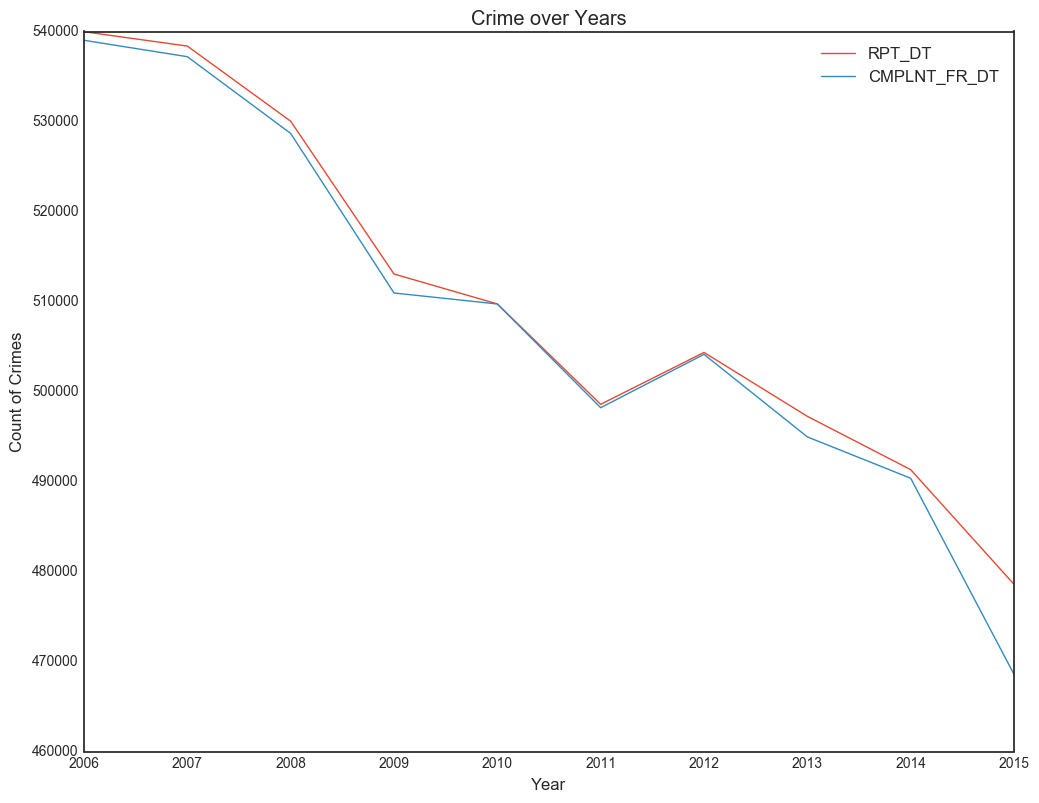

In [96]:
plt.figure(figsize=(12,9))
plt.plot(rpt_by_year_df['year'], rpt_by_year_df['count'], label='RPT_DT')
plt.plot(cmplnt_fr_dt_by_year_df['year'], cmplnt_fr_dt_by_year_df['count'], label='CMPLNT_FR_DT')
plt.legend(loc='best')
plt.xticks(np.arange(2006,2016,1), map(str, np.arange(2006,2016,1)))
plt.title("Crime over Years")
plt.xlabel('Year')
plt.ylabel('Count of Crimes')
plt.legend(loc='best')
plt.savefig('plots/crime_over_year.png')

In [125]:
# only look at years from 2006
rpt_dt_by_month_year = data.filter(lambda x: len(x[RPT_DT])>0) \
              .map(lambda x: (x[RPT_DT].split('/')[0], x[RPT_DT].split('/')[2])) \
              .countByValue()

In [126]:
rpt_dt_by_month_year_df = pd.DataFrame([(row[0][0],row[0][1],row[1]) for row in rpt_dt_by_month_year.items()], columns=['month','year','count'])
rpt_dt_by_month_year_df

,month,year,count
0,06,2006,46199
1,06,2010,44673
2,10,2007,48660
3,11,2010,41700
4,08,2014,44626
5,11,2006,43818
6,11,2008,40923
7,03,2014,40895
8,04,2015,39846
9,09,2015,41942


In [137]:
rpt_dt_df = pd.DataFrame(index=np.arange(1,13))
rpt_dt_df['mean'] = rpt_dt_by_month_year_df.groupby('month')['count'].mean().as_matrix()
rpt_dt_df['std']= rpt_dt_by_month_year_df.groupby('month')['count'].std().as_matrix()
rpt_dt_df['min']= rpt_dt_by_month_year_df.groupby('month')['count'].min().as_matrix()
rpt_dt_df['max']= rpt_dt_by_month_year_df.groupby('month')['count'].max().as_matrix()
rpt_dt_df

,mean,std,min,max
1,41274.1,3526.403409,34533,45370
2,36372.2,2536.421692,31540,39592
3,42390.1,2351.836942,38023,45529
4,41775.0,1413.520782,39846,43621
5,44799.4,1725.974797,42321,47919
6,43938.2,1674.627123,41662,46199
7,45528.5,1082.275381,44379,47239
8,45675.0,1526.890631,43161,47774
9,43791.2,1727.821461,41205,46859
10,44600.0,2375.760089,41250,48660


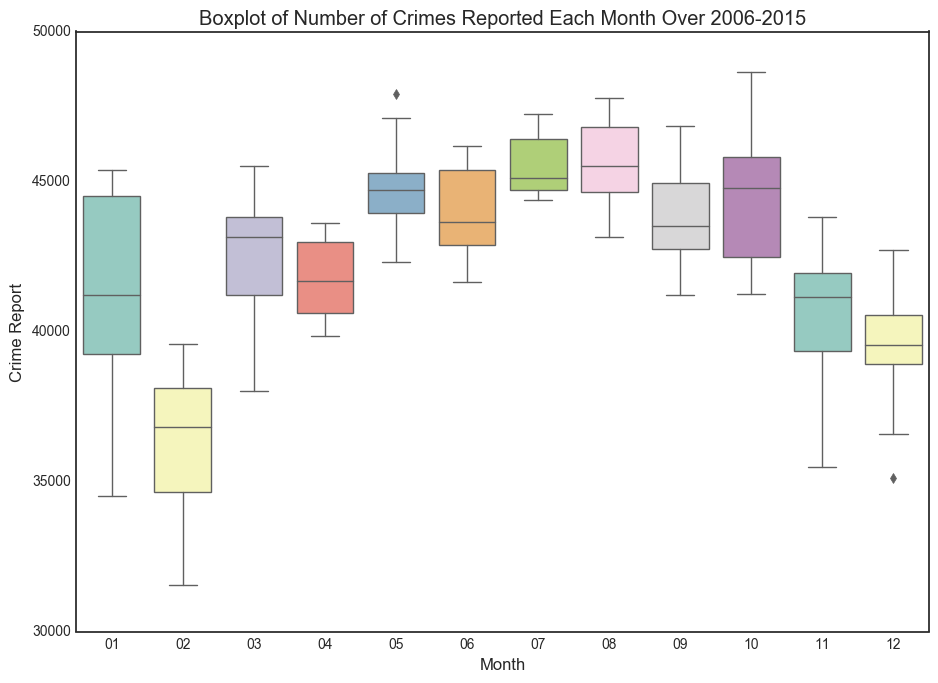

In [176]:
plt.figure(figsize=(11,7.5))
sns.boxplot(x='month', y='count', data=rpt_dt_by_month_year_df, palette=sns.color_palette("Set3", 10))
plt.xlabel('Month')
plt.ylabel('Crime Report')
plt.title('Boxplot of Number of Crimes Reported Each Month Over 2006-2015')
plt.savefig('plots/boxplot_month_year.png')

# Count of Unique Values

In [32]:
# function that returns a dataframe containing counts of values of a column
def count_occurence(colnum):
    # count occurences of boroughs
    count_occurence = data.map(lambda x: x[colnum]) \
                          .filter(lambda x: len(x)>0) \
                          .countByValue()
    return pd.DataFrame(list(count_occurence.items()), columns=[header[colnum],'count']).sort_values(by='count', ascending=False)

In [33]:
law_cat_distrib = count_occurence(LAW_CAT_CD)

In [36]:
law_cat_distrib

,LAW_CAT_CD,count
2,MISDEMEANOR,2918574
0,FELONY,1567423
1,VIOLATION,615234


In [37]:
from pylab import *

In [66]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r,g,b = tableau20[i]
    tableau20[i] = (r/255., g/255., b/255.)

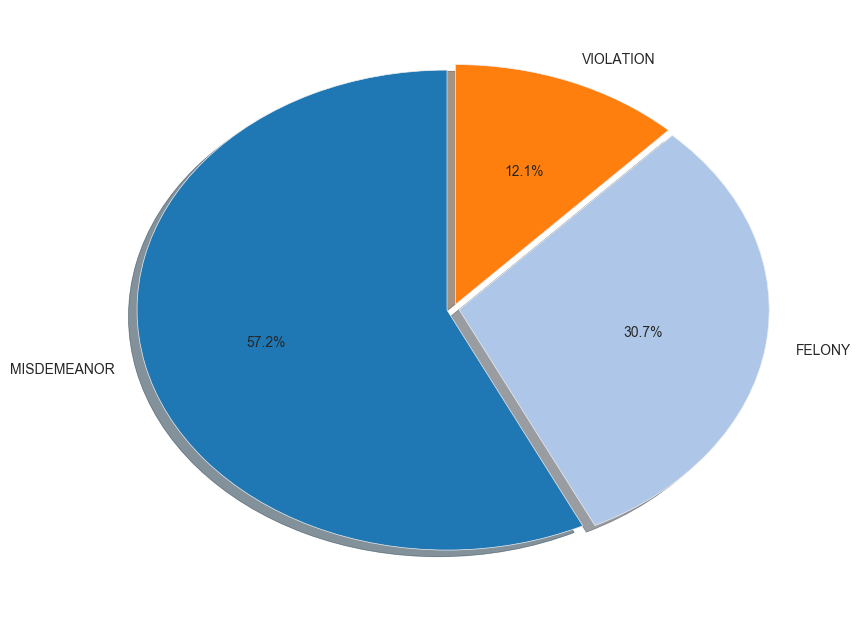

In [94]:
plt.style.use('ggplot')
plt.figure(figsize=(10,7.5))
pie(law_cat_distrib['count'], 
    explode=(0.02,0.02,0.02), 
    shadow=True, 
    startangle=90, 
    autopct='%1.1f%%', 
    labels=law_cat_distrib['LAW_CAT_CD'],
    colors=tableau20,
    );
plt.savefig('plots/law_cat_pie_chart.png')

## Violation Key & Description

In [ ]:
count_occurence(KY_CD)

In [ ]:
count_occurence(OFNS_DESC)

## Boroughs

In [152]:
boro_distrib = data.filter(lambda x: len(x[BORO_NM])>0) \
                   .map(lambda x: (x[BORO_NM], x[LAW_CAT_CD])) \
                   .countByValue()

In [158]:
boro_distrib_df = pd.DataFrame([(row[0][0],row[0][1],row[1]) for row in boro_distrib.items()], columns=['borough','category','count'])


In [159]:
boro_distrib_df

,borough,category,count
0,MANHATTAN,MISDEMEANOR,705614
1,BRONX,VIOLATION,131656
2,MANHATTAN,FELONY,385885
3,BROOKLYN,FELONY,495909
4,STATEN ISLAND,VIOLATION,45123
5,QUEENS,FELONY,338472
6,QUEENS,MISDEMEANOR,544291
7,BROOKLYN,MISDEMEANOR,844865
8,BRONX,FELONY,294643
9,BRONX,MISDEMEANOR,677215


In [137]:
pydata = [go.Bar(x=boro_distrib['BORO_NM'], 
               y=boro_distrib['count'],
               marker=dict(color=['rgba(110,10,110,1)',
                                  'rgba(140,30,140,1)',
                                  'rgba(170,50,170,1)',
                                  'rgba(200,70,200,1)',
                                  'rgba(230,90,230,1)'])),
         ]

py.iplot(pydata)

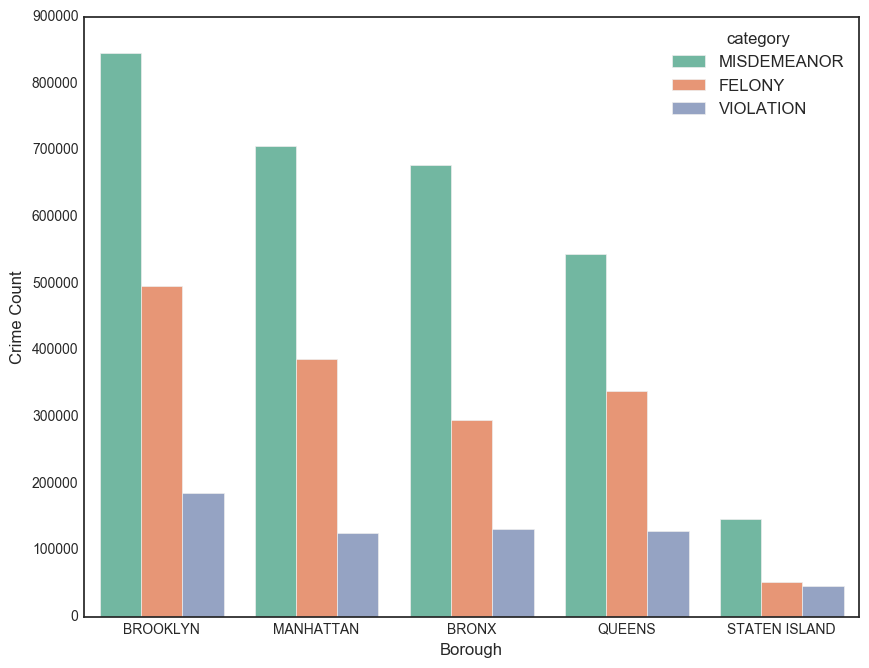

In [172]:
plt.figure(figsize=(10,7.5))
sns.set_style('white')
sns.barplot(x='borough', 
            y='count', 
            order=('BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'), 
            hue='category', hue_order=('MISDEMEANOR', 'FELONY', 'VIOLATION'), 
            data=boro_distrib_df, palette=sns.color_palette("Set2", 10))
plt.xlabel('Borough')
plt.ylabel('Crime Count')
plt.savefig('plots/barplot_borough_by_level.png')

## Precincts

In [97]:
# only look at years from 2006
precinct_distrib = data.filter(lambda x: len(x[ADDR_PCT_CD])>0) \
              .map(lambda x: (x[ADDR_PCT_CD], x[BORO_NM])) \
              .countByValue()

In [106]:
[(row[0][0], row[0][1], row[1]) for row in precinct_distrib.items()]

[('40', 'BRONX', 118896),
 ('69', 'BROOKLYN', 50126),
 ('79', 'BROOKLYN', 81617),
 ('50', 'BRONX', 46599),
 ('9', 'MANHATTAN', 62164),
 ('105', 'QUEENS', 74018),
 ('20', 'MANHATTAN', 40974),
 ('13', 'MANHATTAN', 74442),
 ('121', '', 74),
 ('94', 'BROOKLYN', 33533),
 ('101', 'QUEENS', 41139),
 ('52', 'BRONX', 107178),
 ('26', 'MANHATTAN', 34274),
 ('106', 'BROOKLYN', 1),
 ('30', 'MANHATTAN', 49689),
 ('77', 'BROOKLYN', 76718),
 ('73', 'BROOKLYN', 107097),
 ('41', 'BRONX', 70032),
 ('7', 'BROOKLYN', 1),
 ('18', 'MANHATTAN', 79129),
 ('14', 'MANHATTAN', 119414),
 ('66', 'BROOKLYN', 49609),
 ('63', 'BROOKLYN', 54424),
 ('49', 'BRONX', 68574),
 ('13', 'BROOKLYN', 1),
 ('109', 'QUEENS', 80169),
 ('115', 'QUEENS', 81493),
 ('104', 'MANHATTAN', 1),
 ('61', 'BROOKLYN', 64665),
 ('103', 'QUEENS', 80404),
 ('122', 'STATEN ISLAND', 82693),
 ('76', 'BROOKLYN', 28928),
 ('10', 'MANHATTAN', 43479),
 ('6', 'MANHATTAN', 54904),
 ('17', 'MANHATTAN', 32659),
 ('70', 'BROOKLYN', 81609),
 ('46', 'BRONX', 1

In [107]:
precinct_distrib_df = pd.DataFrame([(row[0][0], row[0][1], row[1]) for row in precinct_distrib.items()], columns=['precinct', 'borough', 'count']).sort_values(by='count', ascending=False)

In [109]:
# precincts with the most crime
precinct_distrib_df.head(10)

,precinct,borough,count
60,75,BROOKLYN,165479
92,43,BRONX,137771
51,44,BRONX,127725
20,14,MANHATTAN,119414
0,40,BRONX,118896
36,46,BRONX,111356
71,120,STATEN ISLAND,109720
11,52,BRONX,107178
16,73,BROOKLYN,107097
62,67,BROOKLYN,94719


In [112]:
# precincts with the least crime
precinct_distrib_df.tail(10)

,precinct,borough,count
87,71,BRONX,1
67,121,BROOKLYN,1
85,25,BRONX,1
27,104,MANHATTAN,1
70,14,BROOKLYN,1
79,104,BROOKLYN,1
52,9,BROOKLYN,1
13,106,BROOKLYN,1
61,6,BRONX,1
47,26,BROOKLYN,1


In [ ]:
pydata = [go.Bar(x=precinct_distrib['ADDR_PCT_CD'], 
               y=precinct_distrib['count'],
               marker=dict(color=['rgba(110,10,110,1)',
                                  'rgba(140,30,140,1)',
                                  'rgba(170,50,170,1)',
                                  'rgba(200,70,200,1)',
                                  'rgba(230,90,230,1)'])),
         ]

py.iplot(pydata)

In [8]:
long_lat = data.filter(lambda x: len(x[LONGTITUDE])>0 and len(x[LATITUDE])>0) \
               .map(lambda x: (float(x[LONGTITUDE]), float(x[LATITUDE]))) \
               .collect()

In [12]:
long_lat_df = pd.DataFrame(long_lat, columns=['long','lat'])

/Users/timhsu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


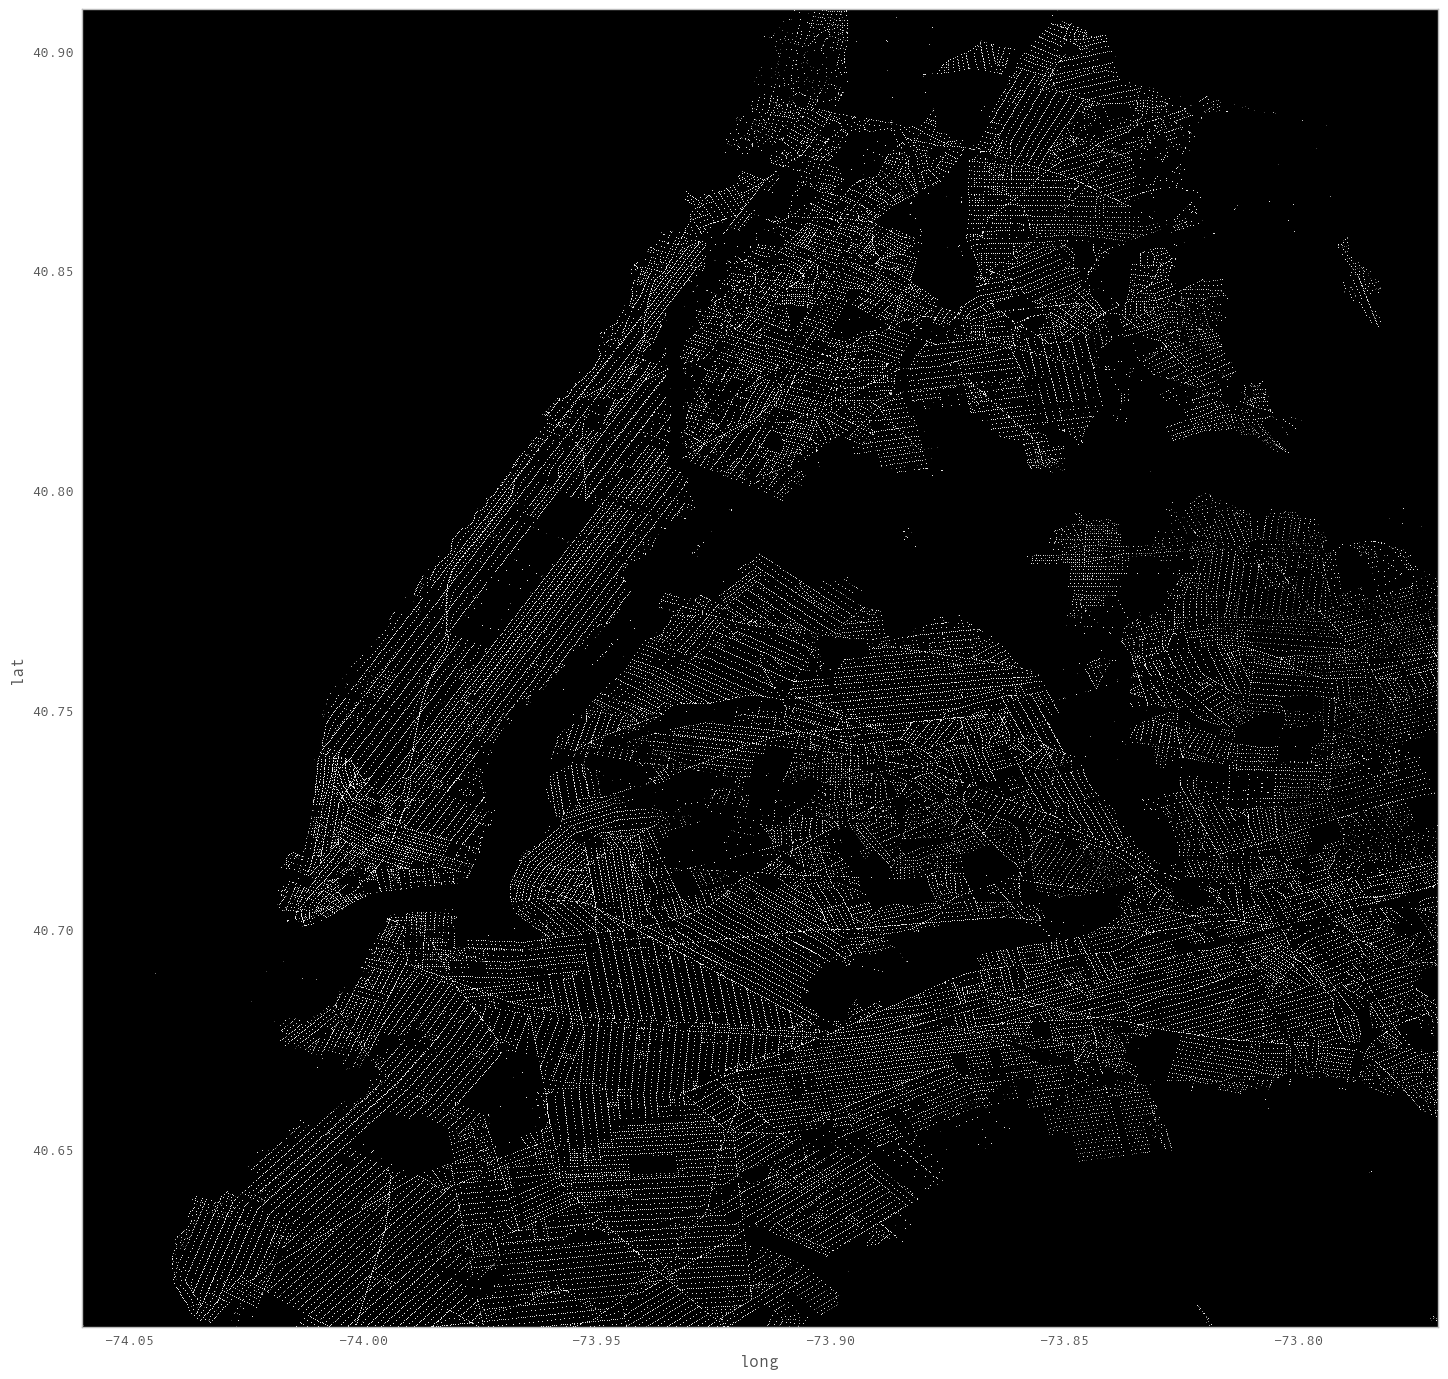

In [14]:
import matplotlib  
import matplotlib.pyplot as plt  
#Inline Plotting for Ipython Notebook 
%matplotlib inline 

pd.options.display.mpl_style = 'default' #Better Styling  
new_style = {'grid': False} #Remove grid  
matplotlib.rc('axes', **new_style)  
from matplotlib import rcParams  
rcParams['figure.figsize'] = (17.5, 17) #Size of figure  
rcParams['figure.dpi'] = 250

P=long_lat_df.plot(kind='scatter', x='long', y='lat',color='white',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('black') #Background Color


In [18]:
import mpl_toolkits
mpl_toolkits.

<module 'mpl_toolkits' from '/Users/timhsu/anaconda/lib/python3.5/site-packages/mpl_toolkits/__init__.py'>

## Parks

In [ ]:
count_occurence(PARKS_NM)

## Premise

In [ ]:
count_occurence(PREM_TYP_DESC)

## Housing Development

In [ ]:
count_occurence(HADEVELOPT)

## Jurisdiction

In [ ]:
count_occurence(JURIS_DESC)